In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.initializers import GlorotUniform

from tensorflow.keras.utils import plot_model

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

### Importing Data Using OS and CountPlot

In [4]:
os.listdir('./train')

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [56]:
os.listdir(os.path.join('train', 'Mild'))

['0024cdab0c1e.png',
 '00cb6555d108.png',
 '0124dffecf29.png',
 '01b3aed3ed4c.png',
 '0369f3efe69b.png',
 '03e25101e8e8.png',
 '04ac765f91a1.png',
 '059bc89df7f4.png',
 '05a5183c92d0.png',
 '0684311afdfc.png',
 '06b71823f9cd.png',
 '07929d32b5b3.png',
 '07a1c7073982.png',
 '086d41d17da8.png',
 '09935d72892b.png',
 '0a3202889f4d.png',
 '0a61bddab956.png',
 '0ad7f631dedb.png',
 '0d310aba6373.png',
 '0dc031c94225.png',
 '0dce95217626.png',
 '0eb52045349f.png',
 '0f495d87656a.png',
 '0fb1053285cf.png',
 '101b9ebfc720.png',
 '107aea0d9289.png',
 '10f36b0239fb.png',
 '1116271db4ea.png',
 '111898ab463d.png',
 '12ce6a1a1f31.png',
 '12e3f5f2cb17.png',
 '13ab8db8c700.png',
 '15cc2aef772a.png',
 '172df1330a60.png',
 '17eff993386f.png',
 '18b06f56ab27.png',
 '194814669fee.png',
 '19722bff5a09.png',
 '19e350c7c83c.png',
 '1a03a7970337.png',
 '1b329a127307.png',
 '1bb0ddfe753a.png',
 '1c0cf251b426.png',
 '1c3a6b4449e9.png',
 '1d11794057ff.png',
 '1d674e2e32e0.png',
 '1df3e03a8f5f.png',
 '1e8a1fdee5b

In [57]:
train = []
label = []

for i in os.listdir('./train'):
    train_class = os.listdir(os.path.join('train', i))
    for j in train_class:
        img = os.path.join('train', i, j)
        train.append(img)
        label.append(i)
        
print(f'Number of train images = {len(train)}')

Number of train images = 3662


<Axes: xlabel='Type', ylabel='count'>

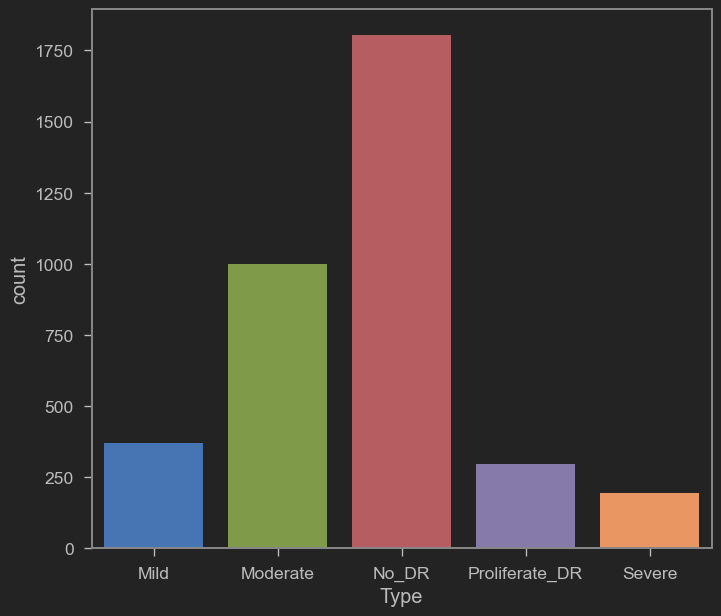

In [7]:
label_df = pd.DataFrame(label, columns = ['Type'])
sns.countplot(x='Type', data=label_df)

### Data Visualization

In [ ]:
# Visualize 5 images for every type of image

fig, axs = plt.subplots(5,5, figsize=(20,20))
count = 0
for i in os.listdir('./train'):
    # get the list of images in a given class
    train_class = os.listdir(os.path.join('train', i))
    # Plot 5 images per class
    for j in range(5):
        img = os.path.join('train', i, train_class[j])
        img = PIL.Image.open(img)
        axs[count][j].title.set_text(i)
        axs[count][j].imshow(img)
    count += 1

fig.tight_layout()

In [ ]:
no_images_per_class = []
class_name = []
for i in os.listdir('./train'):
    train_class = os.listdir(os.path.join('train', i))
    no_images_per_class.append(len(train_class))
    class_name.append(i)
    print(f'# of images in {i} = {len(train_class)} \n')

In [58]:
retina_df = pd.DataFrame({'Image':train, 'label': label} )
retina_df

,Image,label
0,train\Mild\0024cdab0c1e.png,Mild
1,train\Mild\00cb6555d108.png,Mild
2,train\Mild\0124dffecf29.png,Mild
3,train\Mild\01b3aed3ed4c.png,Mild
4,train\Mild\0369f3efe69b.png,Mild
...,...,...
3657,train\Severe\f9156aeffc5e.png,Severe
3658,train\Severe\fb61230b99dd.png,Severe
3659,train\Severe\fcc6aa6755e6.png,Severe
3660,train\Severe\fda39982a810.png,Severe


In [ ]:
fig, ax = plt.subplots()
ax.pie(no_images_per_class, labels = class_name, autopct = '%.2f')

### Data Augmentation and Create Data Generator

In [59]:
#Shuffle the data and split it into training and testing

retina_df = shuffle(retina_df)
retina_df

,Image,label
949,train\Moderate\91e8af9ceee9.png,Moderate
2169,train\No_DR\780be525036d.png,No_DR
37,train\Mild\19722bff5a09.png,Mild
3546,train\Severe\6a244e855d0e.png,Severe
2246,train\No_DR\82d364726a58.png,No_DR
...,...,...
690,train\Moderate\4b5ffea77373.png,Moderate
3621,train\Severe\c3cd0200df79.png,Severe
1479,train\No_DR\10de500cf0c5.png,No_DR
159,train\Mild\63a03880939c.png,Mild


In [60]:
train, test = train_test_split(retina_df, test_size = 0.2) 

In [12]:
# Create a run-time or real-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip

# Image Generator bascially create batches of Images and feed to the model in batches
# Its main use is in data augmentation

# It generate batches of tensor image data with real-time data augmentatio

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, validation_split=0.15, vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
train_generator = train_datagen.flow_from_dataframe(
                train,
                directory = './',
                x_col = "Image",
                y_col = "label",
                target_size = (256, 256),
                color_mode = 'rgb',
                class_mode = 'categorical',
                batch_size = 32,
                subset='training'
                )

validation_generator = train_datagen.flow_from_dataframe(
                train,
                directory = './',
                x_col = "Image",
                y_col = "label",
                target_size = (256, 256),
                color_mode = 'rgb',
                class_mode = 'categorical',
                batch_size = 32,
                subset='validation'
                )

test_generator = test_datagen.flow_from_dataframe(
                test,
                directory = './',
                x_col = "Image",
                y_col = "label",
                target_size = (256, 256),
                color_mode = 'rgb',
                class_mode = 'categorical',
                batch_size = 32
                )


Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


### Build ResNet18 from scratch

In [14]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= GlorotUniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= GlorotUniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [15]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= GlorotUniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= GlorotUniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1[0][0]']        

### Compile and Train

In [16]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verose = 1, save_best_only = True)

In [39]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n//32, epochs = 5, validation_data=validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/5
77/77 [==============================] - 304s 4s/step - loss: 0.4396 - accuracy: 0.8288 - val_loss: 0.7118 - val_accuracy: 0.7692
Epoch 2/5
77/77 [==============================] - 326s 4s/step - loss: 0.4188 - accuracy: 0.8447 - val_loss: 0.6639 - val_accuracy: 0.7885
Epoch 3/5
77/77 [==============================] - 332s 4s/step - loss: 0.3885 - accuracy: 0.8564 - val_loss: 0.9427 - val_accuracy: 0.7692
Epoch 4/5
77/77 [==============================] - 322s 4s/step - loss: 0.3602 - accuracy: 0.8723 - val_loss: 0.8153 - val_accuracy: 0.7788
Epoch 5/5
77/77 [==============================] - 321s 4s/step - loss: 0.3235 - accuracy: 0.8756 - val_loss: 0.7910 - val_accuracy: 0.7644
Epoch 5: early stopping


In [52]:
# Saving entire model, i.e. architecture, weights 

model.save('my_model.keras')
# new_model = tf.keras.models.load_model('saved_model/my_model')

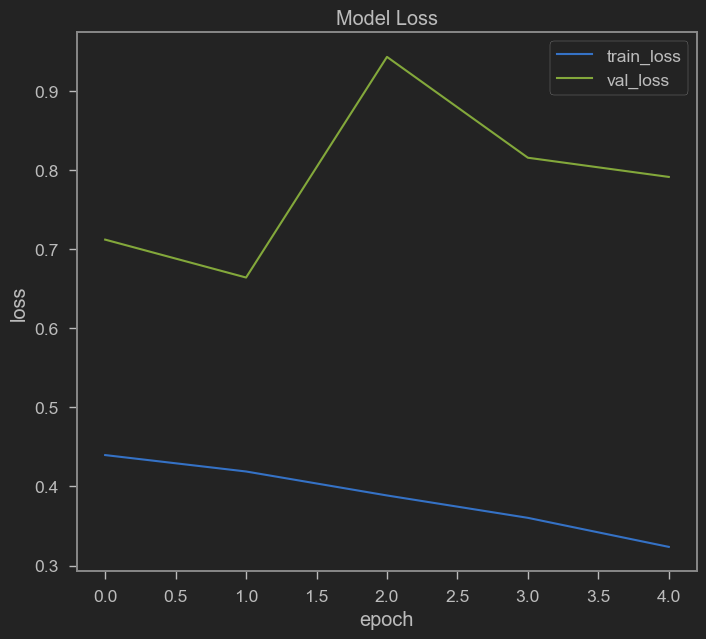

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.show()

### Computing Performance

In [53]:
model.load_weights('weights.hdf5')

In [54]:
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 [==============================] - 18s 819ms/step - loss: 0.6951 - accuracy: 0.7699
Accuracy Test : 0.7698863744735718


In [62]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['label'].tolist()[item])

1/1 [==============================] - 0s 248ms/step


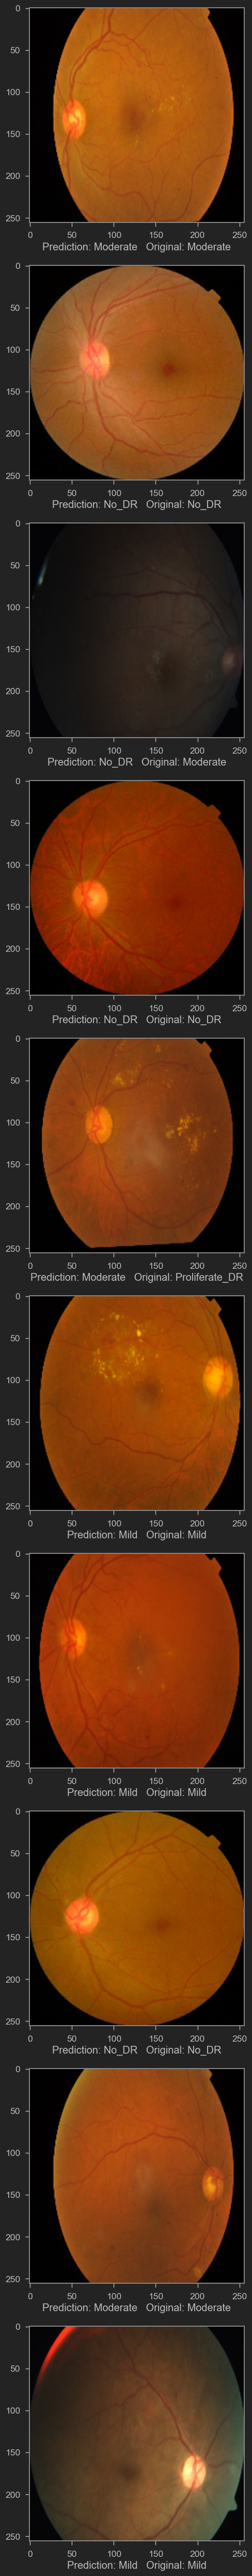

In [68]:
# Visualizing the results
import random
fig=plt.figure(figsize = (50,50))
for i in range(10):
    j = random.randint(0,len(image))
    fig.add_subplot(10, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Confusion_matrix')

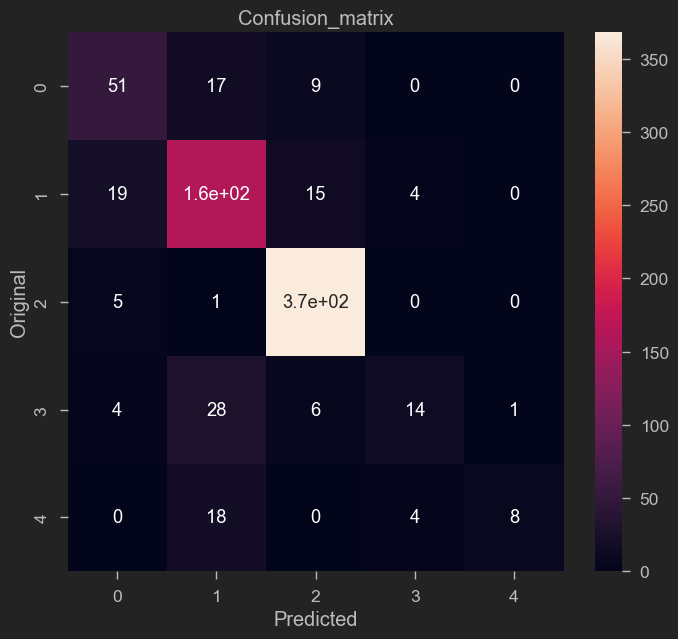

In [69]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')